In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from typing import List, Dict, Any, Tuple
from datetime import datetime  
import re
from pprint import pprint

In [2]:
DPI=300

In [3]:
root_directory = os.path.dirname("../")
logs_directory = os.path.join(root_directory, "logs")
expirements_logs = os.path.join(logs_directory, "logs_2024-03-20T10:48:27")

In [4]:
def get_test_start_end_time(time_json_file) -> Tuple[int, int]:
    with open(time_json_file) as f:
        data = json.load(f)
        return data["start"], data["end"]

In [5]:
def is_valid_timestamp(timestamp):
    pattern = r"^([01]?[0-9]|2[0-3]):[0-5][0-9]:[0-5][0-9] (AM|PM|am|pm)$"
    return bool(re.match(pattern, timestamp))

def extract_mpstat_data_file(filename: str, start_time: int, end_time: int, utah_time):
    with open(filename, "r") as f:
        lines = f.readlines()
    lines = [line.strip() for line in lines if len(line.strip()) != 0]
    start_datetime = datetime.fromtimestamp(int(start_time / 1e9))
    end_datetime = datetime.fromtimestamp(int(end_time / 1e9))
    data_per_second = [0] * int((end_datetime - start_datetime).total_seconds() + 1)
    core_nb = 0
    for line in lines:
        timestamp = line.split()[0] + " " + line.split()[1]
        if not is_valid_timestamp(timestamp):
            continue
        timestamp_datetime = datetime.strptime(timestamp, '%I:%M:%S %p')
        timestamp_datetime = timestamp_datetime.replace(year=start_datetime.year, month=start_datetime.month, day=start_datetime.day)
        if utah_time:
            timestamp_datetime = timestamp_datetime.replace(hour=timestamp_datetime.hour + 7)
        if not (start_datetime <= timestamp_datetime and timestamp_datetime <= end_datetime):
            continue
        core = line.split()[2]
        if core.isdigit():
            core_nb = max(core_nb, core_nb)
            data_per_second[int((timestamp_datetime - start_datetime).total_seconds())] += sum(float(line) for line in line.split()[3:-1])
    return np.array(data_per_second)

def extract_mpstat_data_per_role(role_logs: str, start, end, utah_time: bool):
    mpstat_files = [f for f in os.listdir(role_logs) if f.startswith("mpstat_cpu_util")]
    if len(mpstat_files) == 0:
        raise Exception("No mpstat file found")
    elif len(mpstat_files) > 1:
        raise Exception("More than one mpstat file found")
    return extract_mpstat_data_file(os.path.join(role_logs, mpstat_files[0]), start, end, utah_time)

def extract_mpstat_data_per_run(run_logs: str, utah_time: bool):
    start, end = get_test_start_end_time(os.path.join(run_logs, "client", "time.json"))
    return extract_mpstat_data_per_role(os.path.join(run_logs, "client"), start, end, utah_time), extract_mpstat_data_per_role(os.path.join(run_logs, "server"), start, end, utah_time)

def calculate_over_time_avg(runs_results):
    max_len = max(len(run) for run in runs_results)
    avg_cpu_usage = np.zeros(max_len)
    for i in range(max_len):
        count = 0
        for run_res in runs_results:
            if i < len(run_res):
                avg_cpu_usage[i] = avg_cpu_usage[i] + run_res[i]
                count += 1
        avg_cpu_usage[i] = avg_cpu_usage[i] / count
    return avg_cpu_usage

def extract_mpstat_per_testcase(testcase_logs: str, utah_time: bool):
    runs_dirs = [f for f in os.listdir(testcase_logs) if f.isdigit()]
    clients_runs_results = []
    server_runs_results = []

    for run in runs_dirs:
        clients_runs, server_runs = extract_mpstat_data_per_run(os.path.join(testcase_logs, run), utah_time)
        clients_runs_results.append(clients_runs)
        server_runs_results.append(server_runs)
    
    return  calculate_over_time_avg(clients_runs_results), calculate_over_time_avg(server_runs_results)

def axe_plot(ax: plt.Axes, cpu_util_per_sec, title: str):
    ax.plot(range(len(cpu_util_per_sec)), cpu_util_per_sec, label="CPU Utilization", linestyle="dashdot")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("CPU Utilization (%)")
    ax.set_title(title)
    ax.grid(which='major', zorder=0, linestyle="dashed")

def plot_mpstat_impl(implementation_logs: str, impl_name: str, utah_time: bool):
    client_cpu_util, server_cpu_util = extract_mpstat_per_testcase(os.path.join(implementation_logs, "goodput"), utah_time)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=DPI, sharey=True)
    fig.subplots_adjust(hspace=0.5)  # Add margin between rows
    fig.suptitle(f"{impl_name} - CPU Utilization on a Ten-core Intel E5-2640v4 at 2.4 GHz")
    axe_plot(axes[0], client_cpu_util, "Client")
    axe_plot(axes[1], server_cpu_util, "Server")

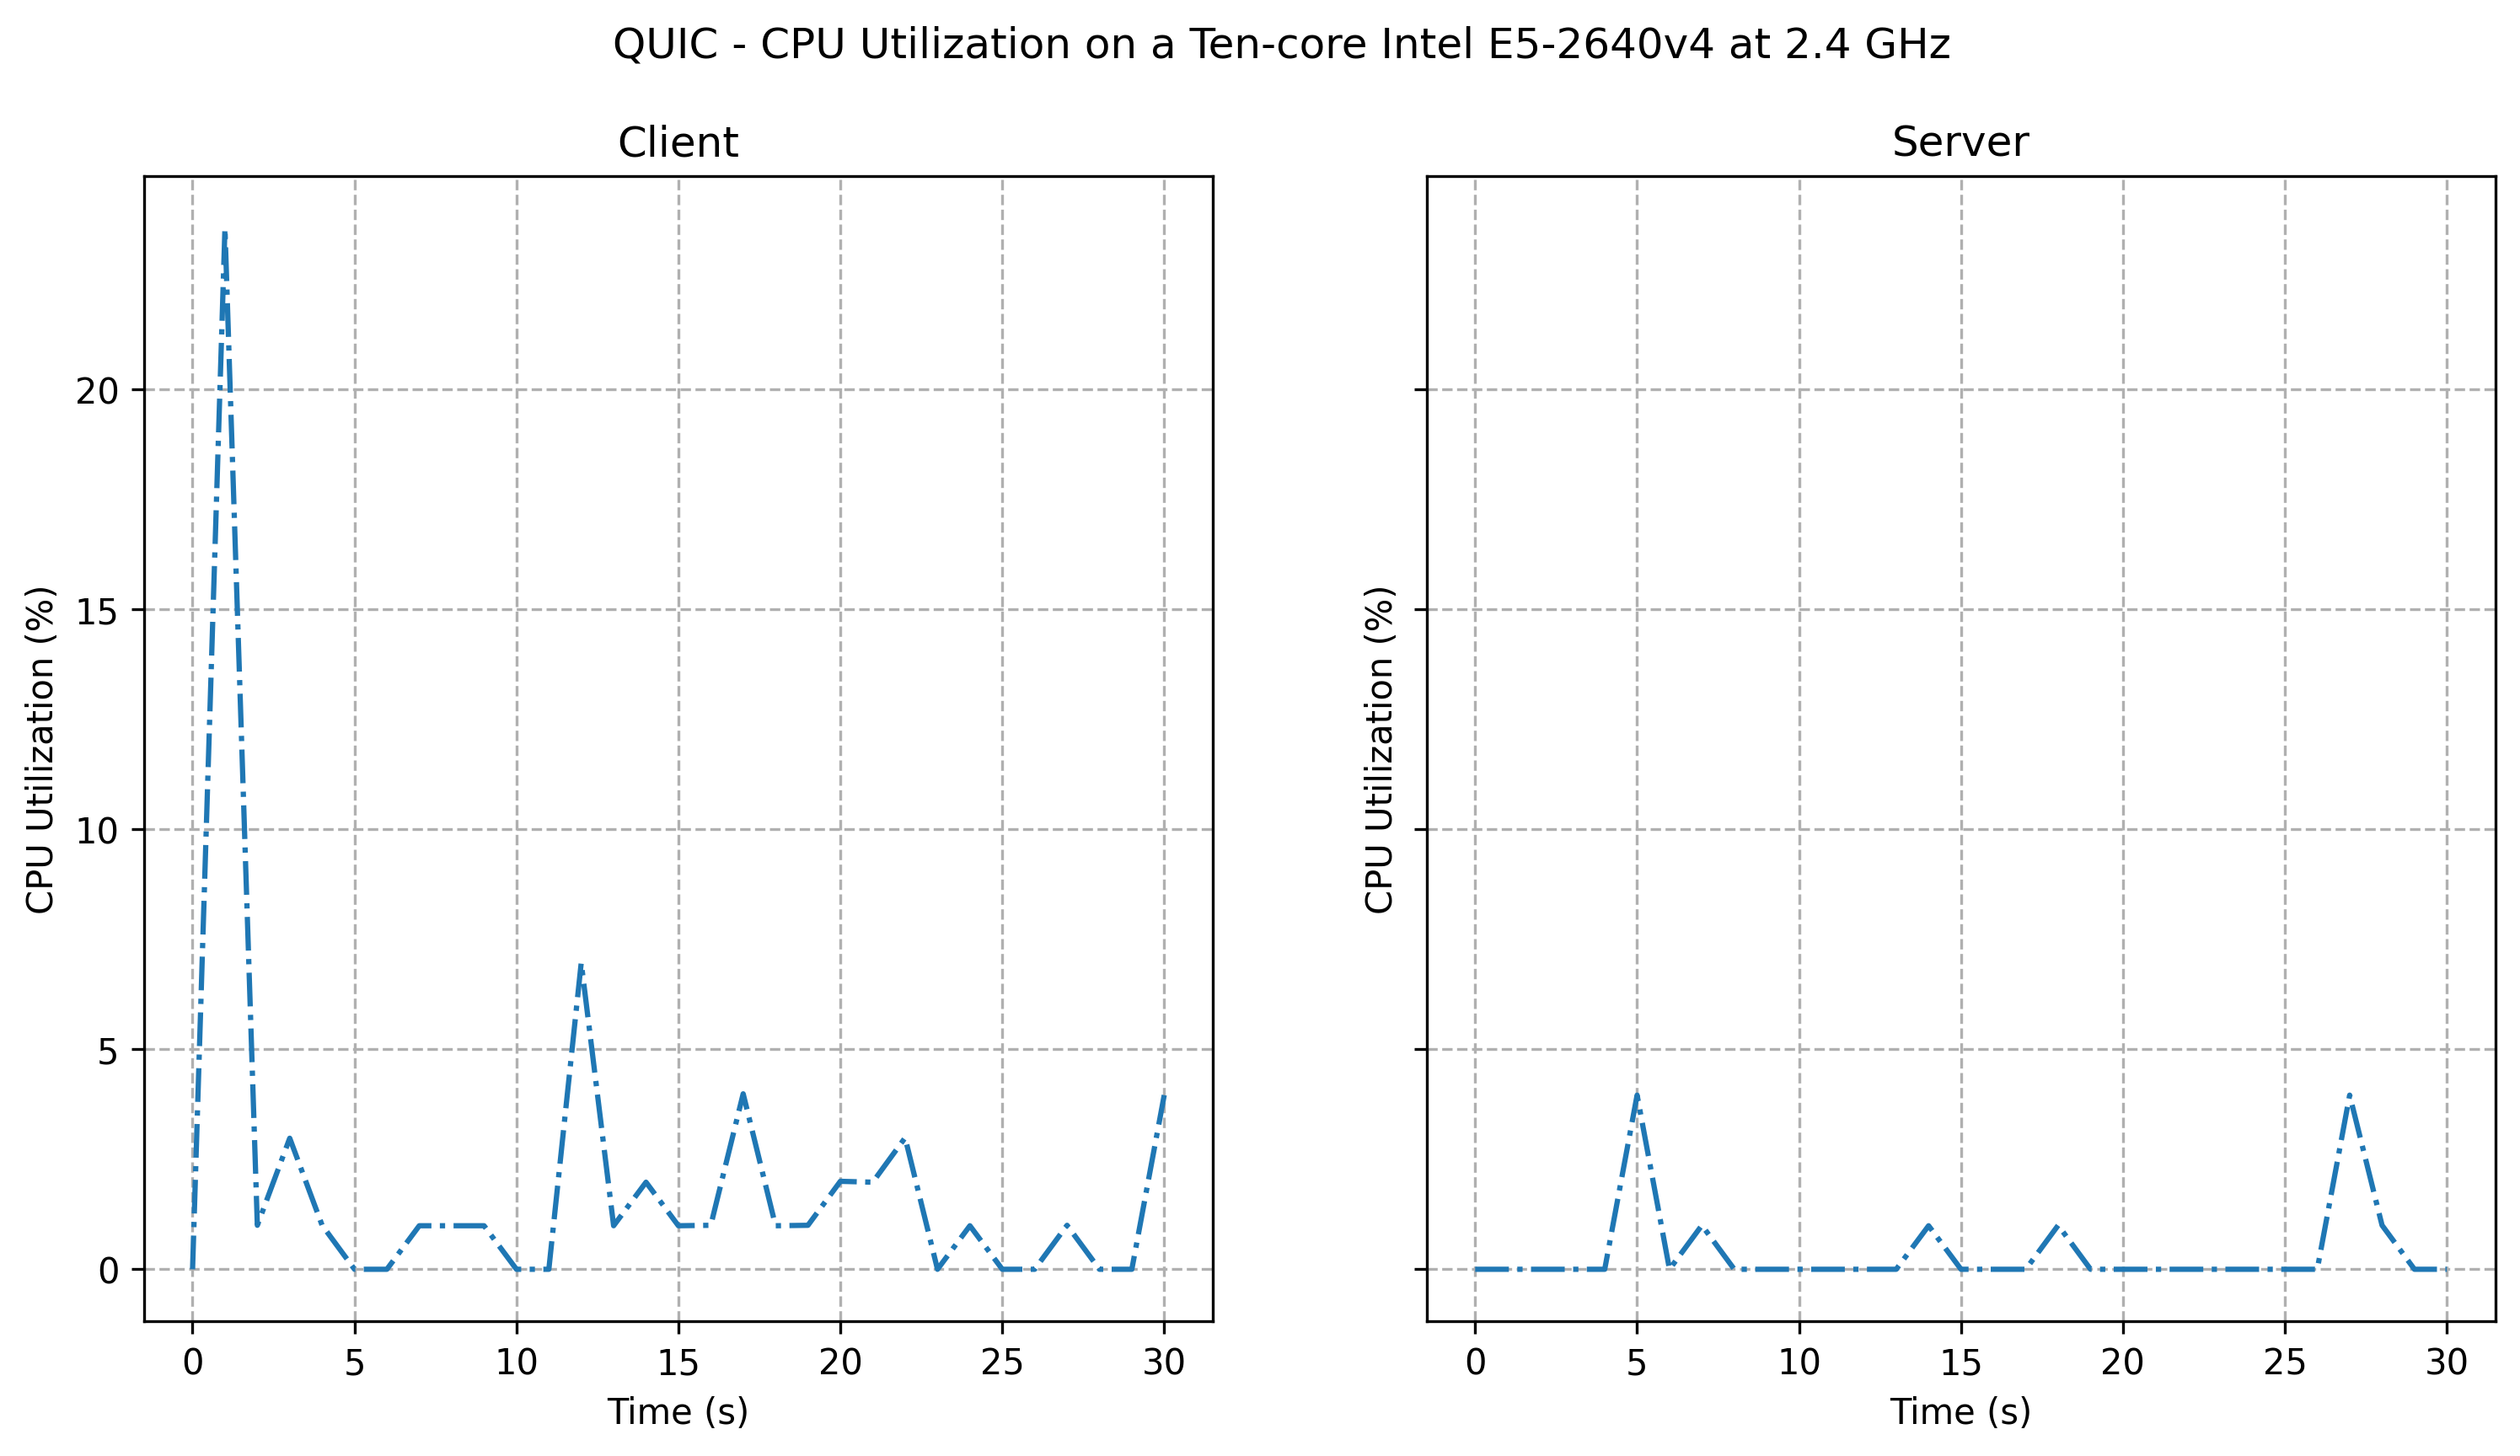

In [6]:
plot_mpstat_impl(os.path.join(expirements_logs, "quic_quic"), "QUIC", utah_time=False)
plt.show()

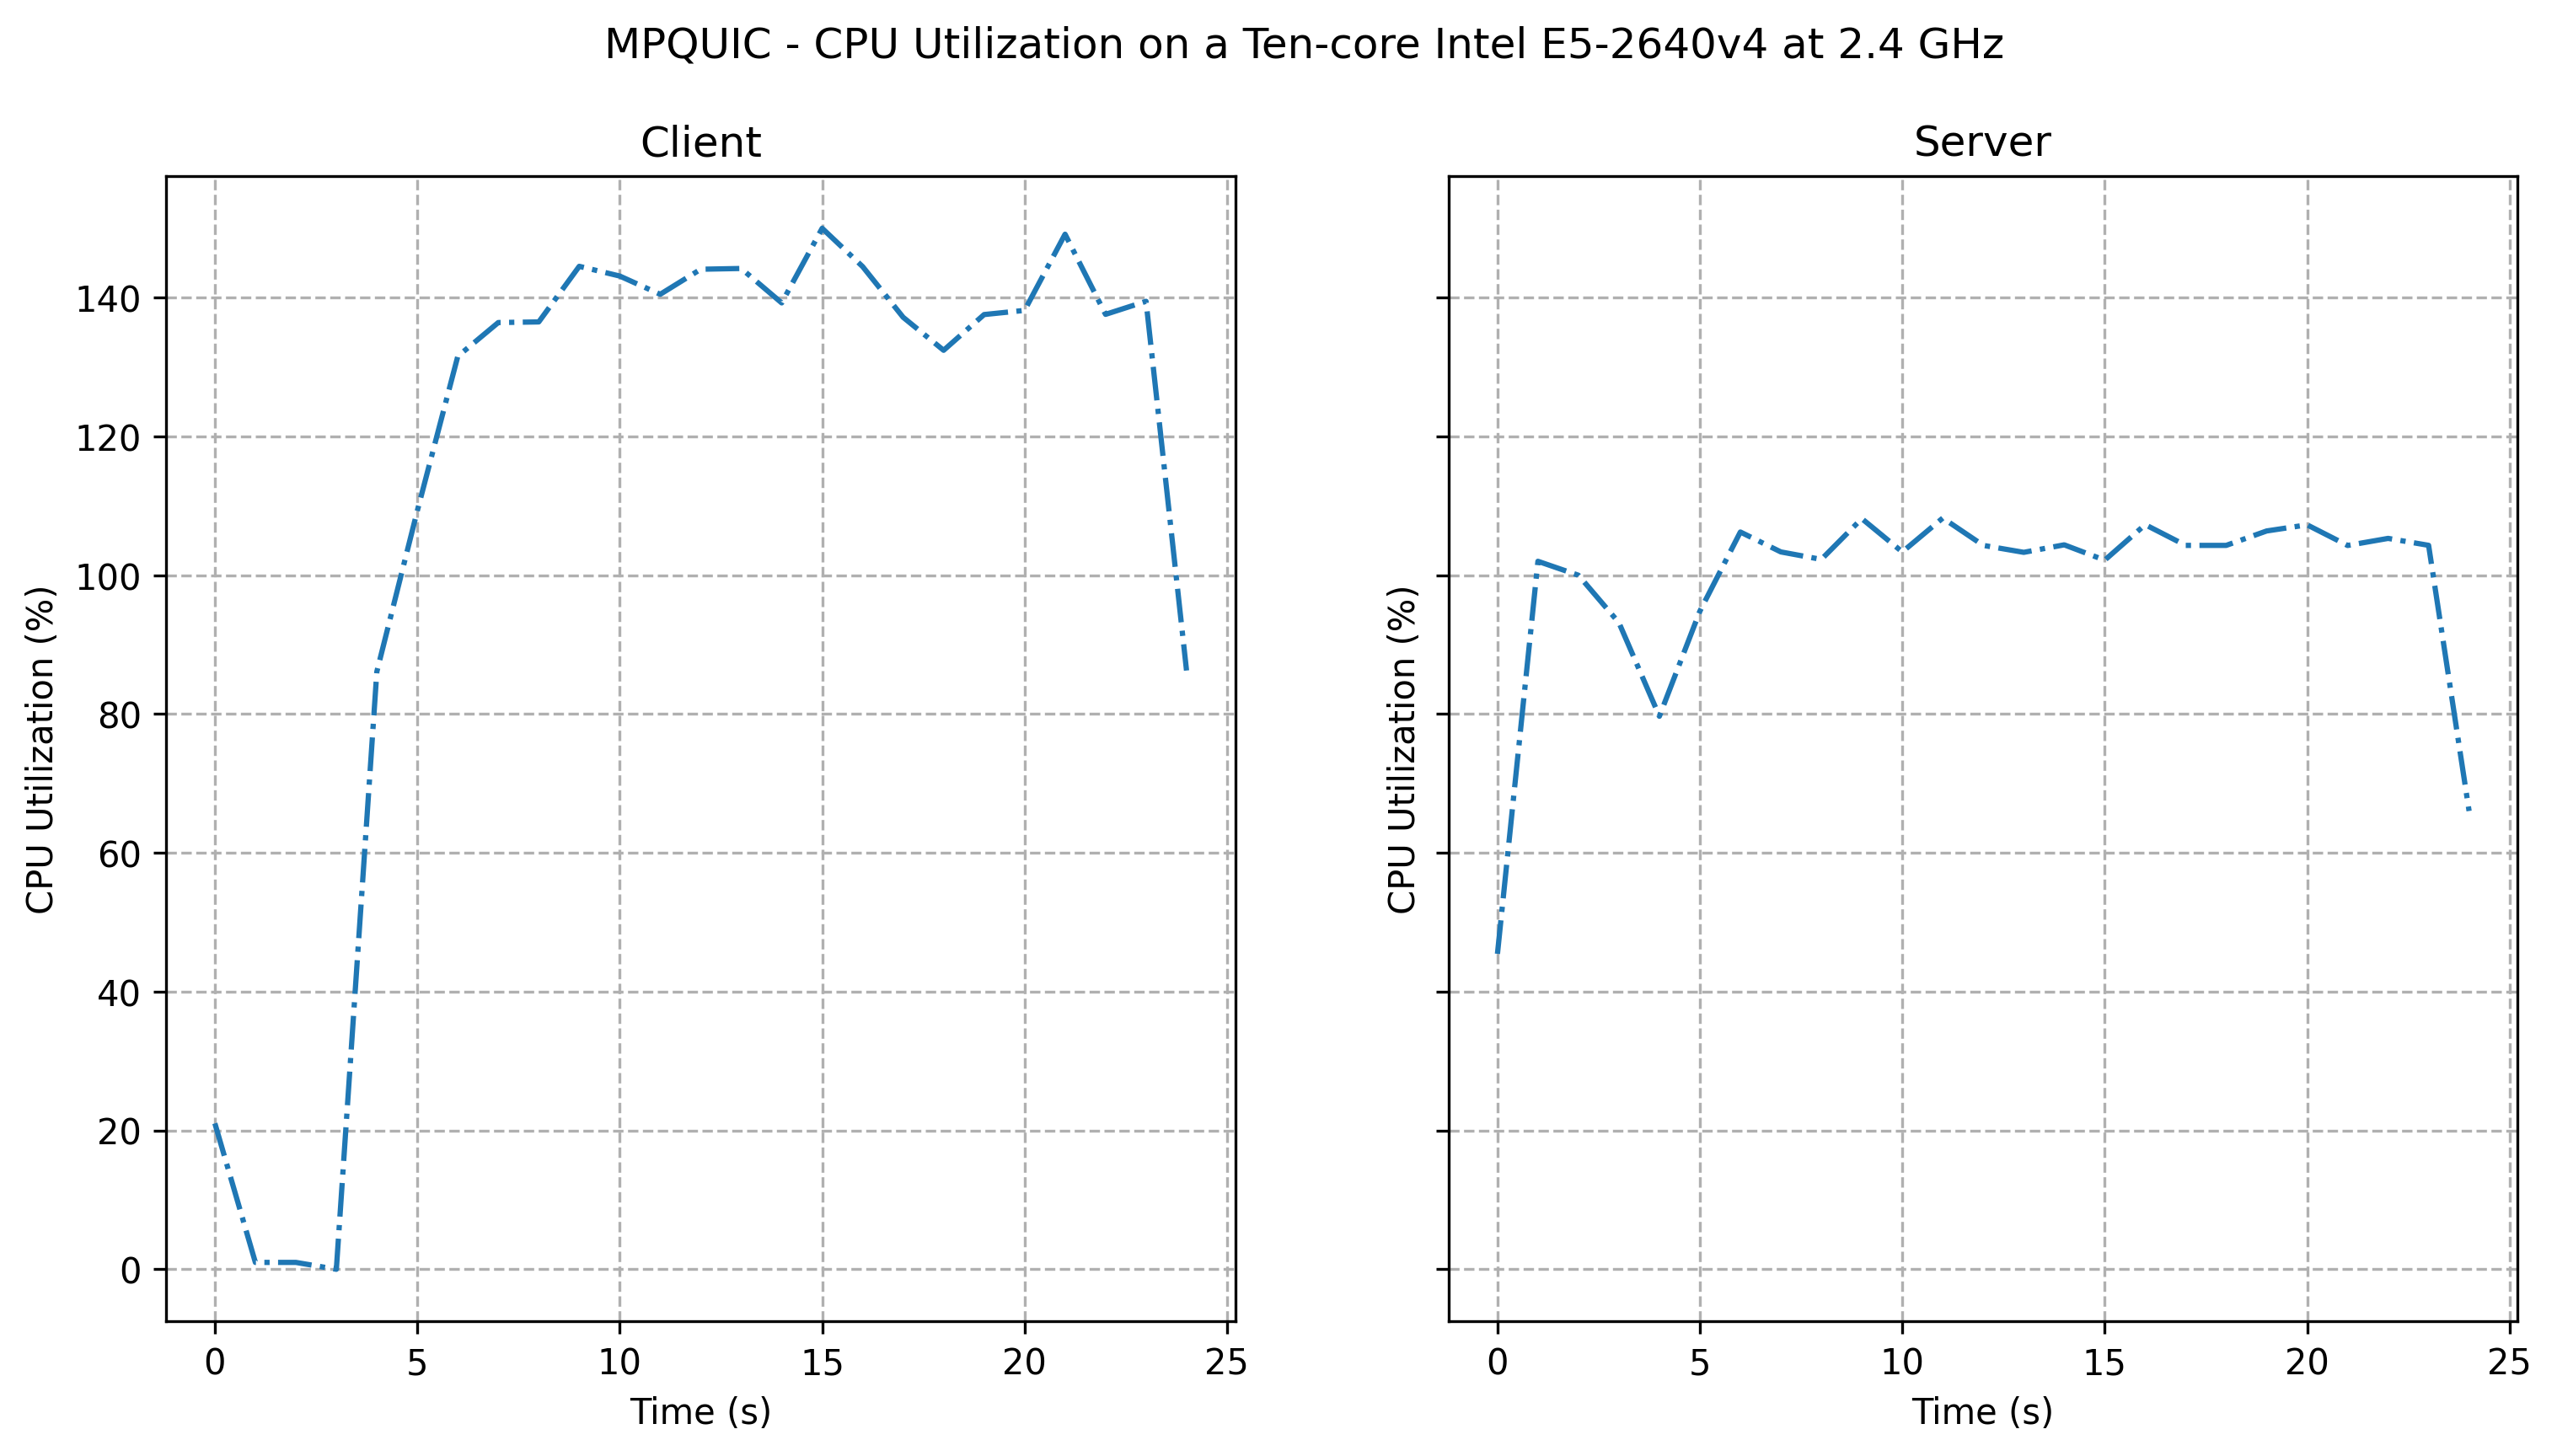

In [8]:
plot_mpstat_impl(os.path.join(expirements_logs, "mpquic_mpquic"), "MPQUIC", utah_time=False)
plt.show()

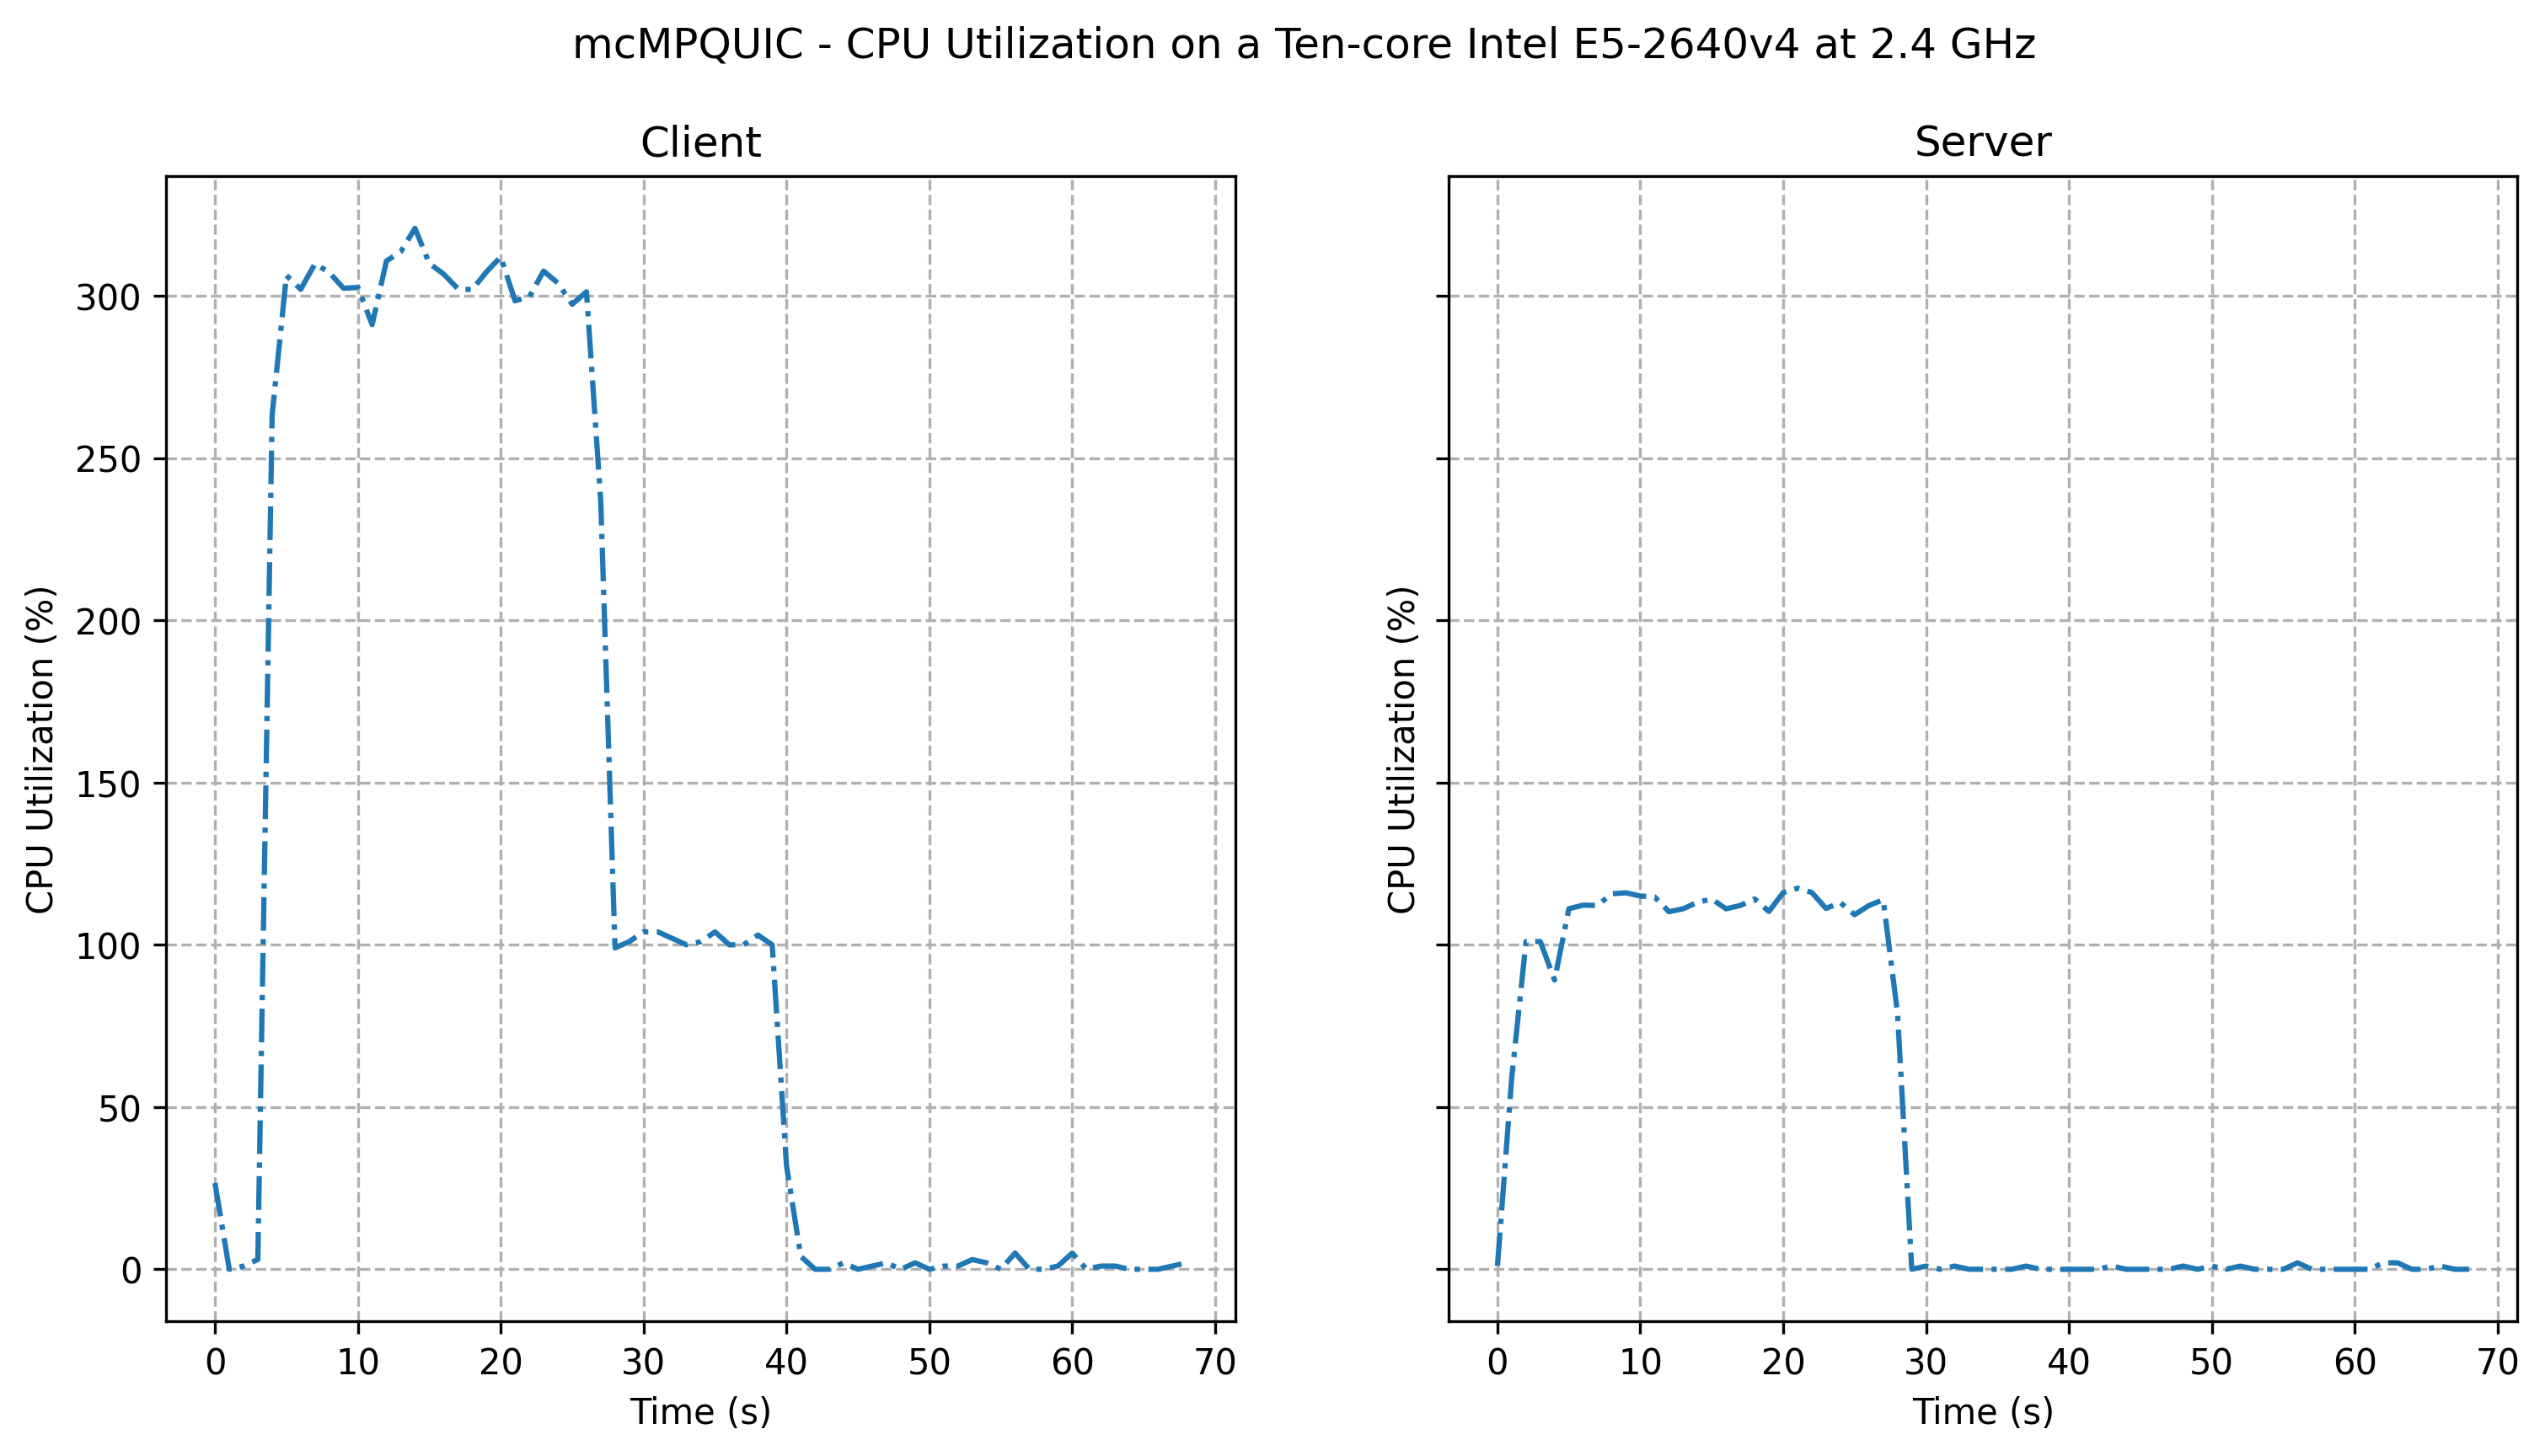

In [9]:
plot_mpstat_impl(os.path.join(expirements_logs, "mcmpquic_mcmpquic"), "mcMPQUIC", utah_time=False)
plt.show()